# How are freshman backpacks coming off the C1?

## Question:
Does perceived sex (Male vs Female) predict which shoulder (Left, Right, Both, or Neither) a student uses to carry their backpack when getting off the C1 bus?

## Rationale:
Observing how students carry backpacks offers a simple behavioral dataset for testing categorical prediction. While trivial on its face, it demonstrates how to structure a behavioral observation into a formal contingency table suitable for hypothesis testing.

## Operational Notes:
- Students seated on the bus may hold the backpack on their lap rather than wear it.
- “Getting off the bus” is the key observation moment, students must reorient or lift the backpack, revealing shoulder choice.
- Rain (especially this last week) likely impacted the student choice.
- Perceived sex is coded visually (M/F) and may not correspond perfectly to actual sex or gender identity. This should be noted as a limitation.

## Power Law for Chi-Square's Test for Indepedence

The chi-square test of independence is appropriate because:
- Both variables (perceived sex and shoulder choice / lack-thereof) are categorical and nominal.
- We are testing whether the distribution of shoulder choices differs by sex.
- It makes no assumption about ordering or directionality, only association.

The power law used here expresses that the noncentrality parameter ($\lambda$) grows with both effect size ($w$) and sample size ($n$):

$$
\lambda = n w^2
$$

Power increases with $\lambda$, meaning:
- Larger effects (greater $w$) or
- Larger samples (greater $n$)
make it more likely to detect an association.

In practical terms, even a small effect (i.e. $w = 0.1$) requires several hundred observations for 80% power at α = 0.05, while a medium effect (i.e. $w = 0.3$) could be detected with fewer than 150 observations (see below).

This defines the observational effort needed before moving to live C1 data collection.


In [1]:
import numpy as np
from numpy.ma.core import concatenate
from scipy.stats import ncx2, chi2

def n_for_power(w, df=3, alpha=0.05, power=0.80):
    crit = chi2.ppf(1-alpha, df)
    lo, hi = 1, 1_000_000
    for _ in range(60):
        mid = (lo+hi)//2
        nc = mid*(w**2)
        p = 1 - ncx2.cdf(crit, df, nc)
        if p >= power: hi = mid
        else: lo = mid+1
    return lo

effect_sizes = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]

for w in effect_sizes:
    n_needed = n_for_power(w, df=3, alpha=0.05, power=0.8)
    print(f"w = {w},  required n : {n_needed}")


w = 0.05,  required n : 4362
w = 0.1,  required n : 1091
w = 0.15,  required n : 485
w = 0.2,  required n : 273
w = 0.25,  required n : 175
w = 0.3,  required n : 122


Text(0.5, 1.0, 'Power Analysis: Sample Size vs. Effect Size (w)')

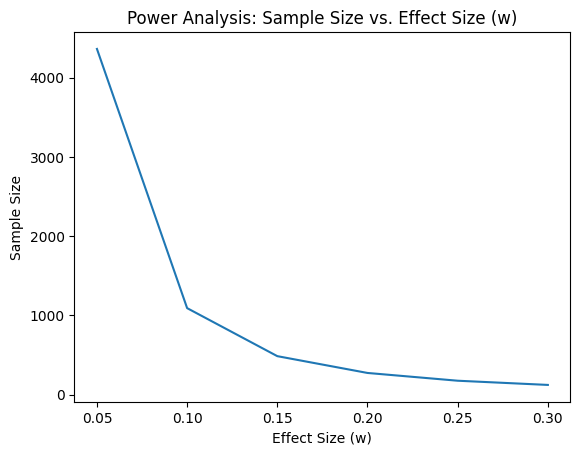

In [2]:
import matplotlib.pyplot as plt
plt.plot(effect_sizes, [n_for_power(w) for w in effect_sizes])
plt.xlabel('Effect Size (w)')
plt.ylabel('Sample Size')
plt.title('Power Analysis: Sample Size vs. Effect Size (w)')

As effect size increases from 0.05 to 0.10, the required sample size decreases by approx. 3000 observations. However, from 0.10 to 0.15 it decreaess only by approx. 500. The reduction becomes much less dramatic at further increases to effect size.

Represents diminishing returns for detecting smaller differences, which require much more data.

# Data

Data Was Collected Via Counting C1 departures. and is located in `data/backpack_counts.xlsx` update when finished

It will either be a raw tally or list of  "Code" i.e. ml - codes for male left.

In [3]:
import pandas as pd

data_dir = "data"

files = ["dominic_obs.csv", "roshan_obs.csv"]

dfs = []
for f in files:
    path = data_dir + "/" + f
    df = pd.read_csv(path, index_col=0)
    df.columns = ["Female", "Male"]
    df.index.name = "Shoulder"
    dfs.append(df)

combined = sum(dfs)

print(combined)

          Female  Male
Shoulder              
B            218   104
L             32    26
R             83    60
N             28    51


# Stats

Chi-Squared on Both

In [4]:
from scipy.stats import chi2_contingency

chi2, p, dof, expected = chi2_contingency(combined)

print("Chi-Squared Test of Independence")
print(f"Chi-Squared statistic: {chi2}")
print(f"Degrees of freedom: {dof}")
print(f"p-value: {p:}")

Chi-Squared Test of Independence
Chi-Squared statistic: 28.59228010299256
Degrees of freedom: 3
p-value: 2.727671314471471e-06


In [5]:
import numpy as np

residuals = (combined - expected) / np.sqrt(expected)
print("Standardized Residuals:")
print(residuals.round(2))

Standardized Residuals:
          Female  Male
Shoulder              
B           1.79 -2.19
L          -0.47  0.58
R          -0.30  0.36
N          -2.81  3.45


# What if Left / Right is One Shoulder as a Bucket

In [6]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

one_shoulder = (
    combined.rename(index={"L": "One", "R": "One"})
    .groupby(level=0)
    .sum()
)

print("One Shoulder Table:")
print(one_shoulder)

chi2_o, p_o, dof_o, expected_o = chi2_contingency(one_shoulder)
print("Chi-Squared Test of Independence")
print(f"Chi-Squared = {chi2_o}")
print(f"Degrees of freedom = {dof_o}")
print(f"p-value = {p_o}")

expected_o = pd.DataFrame(expected_o, index=one_shoulder.index, columns=one_shoulder.columns)
residuals = (one_shoulder - expected_o) / np.sqrt(expected_o)
print("Standardized Residuals:")
print(residuals.round(2))


One Shoulder Table:
          Female  Male
Shoulder              
B            218   104
N             28    51
One          115    86
Chi-Squared Test of Independence
Chi-Squared = 28.45074552194501
Degrees of freedom = 2
p-value = 6.637417054453642e-07
Standardized Residuals:
          Female  Male
Shoulder              
B           1.79 -2.19
N          -2.81  3.45
One        -0.50  0.62
